In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
import torch.utils.data as data_utils
import torch.nn as nn
import torch.nn.functional as F
from datetime import datetime

In [ ]:
transform = transforms.Compose(
    [transforms.Resize(255), transforms.CenterCrop(224), transforms.ToTensor()]
)

In [ ]:
dataset = datasets.ImageFolder("/content/drive/MyDrive/Plant_leave_diseases_dataset_with_augmentation", transform=transform)
loader = data_utils.DataLoader(dataset, batch_size=32, shuffle=True)
class_labels = dataset.classes

In [ ]:
dataset_length = len(dataset)
indices = list(range(dataset_length))
np.random.shuffle(indices)

In [ ]:
split_1 = int(0.8 * dataset_length)
split_2 = int(0.9 * dataset_length)

train_indices = indices[:split_1]
validation_indices = indices[split_1:split_2]
test_indices = indices[split_2:]

In [ ]:
train_size = len(train_indices)
validation_size = len(validation_indices)
test_size = len(test_indices)

print(f"Length of train set: {train_size}")
print(f"Length of validation set: {validation_size}")
print(f"Length of test set: {test_size}")

Length of train set: 48939
Length of validation set: 6117
Length of test set: 6118


In [ ]:
train_sampler = SubsetRandomSampler(train_indices)
validation_sampler = SubsetRandomSampler(validation_indices)
test_sampler = SubsetRandomSampler(test_indices)

In [ ]:
targets_size = len(dataset.class_to_idx)

In [ ]:
class CNN(nn.Module):
    def __init__(self, K):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            # conv1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            # conv2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            # conv3
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            # conv4
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),
            # Additional conv layer
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
        )

        self.dense_layers = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(50176, 1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, K),
        )

    def forward(self, X):
        out = self.conv_layers(X)

        out = out.view(-1, 50176)

        out = self.dense_layers(out)

        return out


In [ ]:
model = CNN(targets_size)

In [ ]:
from torchsummary import summary

summary(model, (3, 224, 224))

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
def batch_gd(model, criterion, train_loader, test_laoder, epochs):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    validation_losses = np.zeros(epochs)

    for e in range(epochs):
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            inputs, targets = inputs.cuda(), targets.cuda()

            optimizer.zero_grad()

            output = model(inputs)

            loss = criterion(output, targets)

            train_loss.append(loss.item())

            loss.backward()
            optimizer.step()

        train_loss = np.mean(train_loss)

        validation_loss = []

        for inputs, targets in validation_loader:

            inputs, targets = inputs.cuda(), targets.cuda()

            output = model(inputs)

            loss = criterion(output, targets)

            validation_loss.append(loss.item())

        validation_loss = np.mean(validation_loss)

        train_losses[e] = train_loss
        validation_losses[e] = validation_loss

        dt = datetime.now() - t0

        print(
            f"Epoch : {e+1}/{epochs} Train_loss:{train_loss:.3f} Test_loss:{validation_loss:.3f} Duration:{dt}"
        )

    return train_losses, validation_losses

In [ ]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=train_sampler
)
test_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=test_sampler
)
validation_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=validation_sampler
)

In [ ]:
train_losses, validation_losses = batch_gd(
    model, criterion, train_loader, validation_loader, 10
)

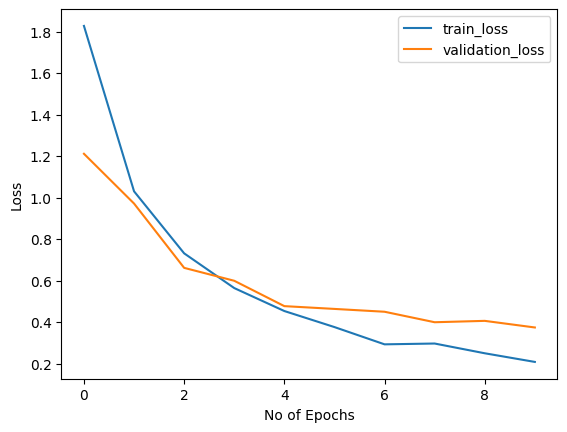

In [ ]:
plt.plot(train_losses , label = 'train_loss')
plt.plot(validation_losses , label = 'validation_loss')
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
torch.save(model.state_dict() , '/content/plant_disease_model_2.pt')

In [ ]:
targets_size = 39
device = torch.device('cpu')
model = CNN(targets_size)
model.load_state_dict(torch.load("/content/drive/MyDrive/Saved_Model/plant_disease_model.pt", map_location = device))
model.eval()

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

In [ ]:
import torch
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def accuracy(loader):
    n_correct = 0
    n_total = 0
    y_true = []
    y_pred = []

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)

        _, predictions = torch.max(outputs, 1)

        n_correct += (predictions == targets).sum().item()
        n_total += targets.shape[0]

        y_true.extend(targets.tolist())
        y_pred.extend(predictions.tolist())

    acc = n_correct / n_total
    return acc, y_true, y_pred

train_acc, train_true, train_pred = accuracy(train_loader)
test_acc, test_true, test_pred = accuracy(test_loader)
validation_acc, validation_true, validation_pred = accuracy(validation_loader)

# Calculate confusion matrix
train_cm = confusion_matrix(train_true, train_pred)
test_cm = confusion_matrix(test_true, test_pred)
validation_cm = confusion_matrix(validation_true, validation_pred)

# Plot confusion matrix heat maps
def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

class_names = class_labels
plot_confusion_matrix(train_cm, class_names)
plot_confusion_matrix(test_cm, class_names)
plot_confusion_matrix(validation_cm, class_names)


In [ ]:
print(
    f"Train Accuracy : {train_acc*100 :.3f}\nValidation Accuracy : {validation_acc*100 : .3f}\nTest Accuracy : {test_acc*100 :.3f}"
)

Train Accuracy : 99.080
Validation Accuracy :  95.612
Test Accuracy : 95.978


In [ ]:
transform_index_to_disease = dataset.class_to_idx

In [ ]:
transform_index_to_disease = dict(
    [(value, key) for key, value in transform_index_to_disease.items()]
)

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Saved_Model/disease_info.csv", encoding="cp1252")

In [ ]:
from PIL import Image
import torchvision.transforms.functional as TF

In [ ]:
def single_prediction(image_path):
    image = Image.open(image_path)
    image = image.resize((224, 224))
    input_data = TF.to_tensor(image)
    input_data = input_data.view((-1, 3, 224, 224))
    output = model(input_data)
    output = output.detach().numpy()
    index = np.argmax(output)
    print("Original : ", image_path[:-4])
    pred_csv = data["disease_name"][index]
    print(pred_csv)

In [ ]:
single_prediction("/content/drive/MyDrive/test2.jpg")